# TimeSeries Project (e-commerce dataset)

Problems encountered in dataset:
- Columns separated with character (')
- Float separated with comma 
- Totale column with negative values

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Import dataset and formatting types

In [116]:
df = pd.read_csv('.\data\serie-storiche-ecommerce.csv', quotechar="'", parse_dates=["data"])
df["totale"] = df["totale"].apply(lambda x : (x.replace(",", ".")))
df["totale"] = df["totale"].astype(float)
df.sort_values('data', inplace=True)
df.head()

,data,totale,settore
0,2013-02-01,815.97,Calcio
1,2013-02-21,4775.75,Fitness
2,2013-04-01,4775.75,Fitness
3,2013-04-06,1962.15,Casual
4,2013-07-09,1809.87,Basket


In [117]:
### descriptive analysis on total column
df["totale"].describe()

count     25261.000000
mean       7886.239314
std       13273.856514
min       -2159.180000
25%        1335.300000
50%        3948.860000
75%       10209.730000
max      516104.930000
Name: totale, dtype: float64

In [118]:
df.isnull().sum()

data       0
totale     0
settore    0
dtype: int64

In [119]:
df = df[df["totale"]>0]

### Data exploration

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25227 entries, 0 to 25260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     25227 non-null  datetime64[ns]
 1   totale   25227 non-null  float64       
 2   settore  25227 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 788.3+ KB


In [121]:
### descriptive analysis on total column
df["totale"].describe()

count     25227.000000
mean       7896.953680
std       13279.580998
min           0.270000
25%        1337.210000
50%        3966.870000
75%       10224.470000
max      516104.930000
Name: totale, dtype: float64

In [122]:
### Check for missing days
from datetime import timedelta

### Group by per data to sum total earnings
df_sells_day = pd.DataFrame(df.groupby(by="data", sort=True, as_index=False)["totale"].sum())

list_missing_dates = []
previous_date = df_sells_day['data'][0] - timedelta(days=1)
for date in df_sells_day['data']:
    if date-timedelta(days=1) != previous_date:
        list_missing_dates.append(date)
    previous_date = date

print('Last date with missing previous day: ' + str(list_missing_dates[-1]))

Last date with missing previous day: 2014-02-20 00:00:00


In [123]:
### Keep only days after the 2014-02-20 and discard the last day too (very low value, could be partial data, maybe extracted not at the end of the day)
df_sells_day = df_sells_day[(df_sells_day['data'] > '2014-02-20') & (df_sells_day['data'] < '2022-04-08')]

(15862.0, 19357.0)

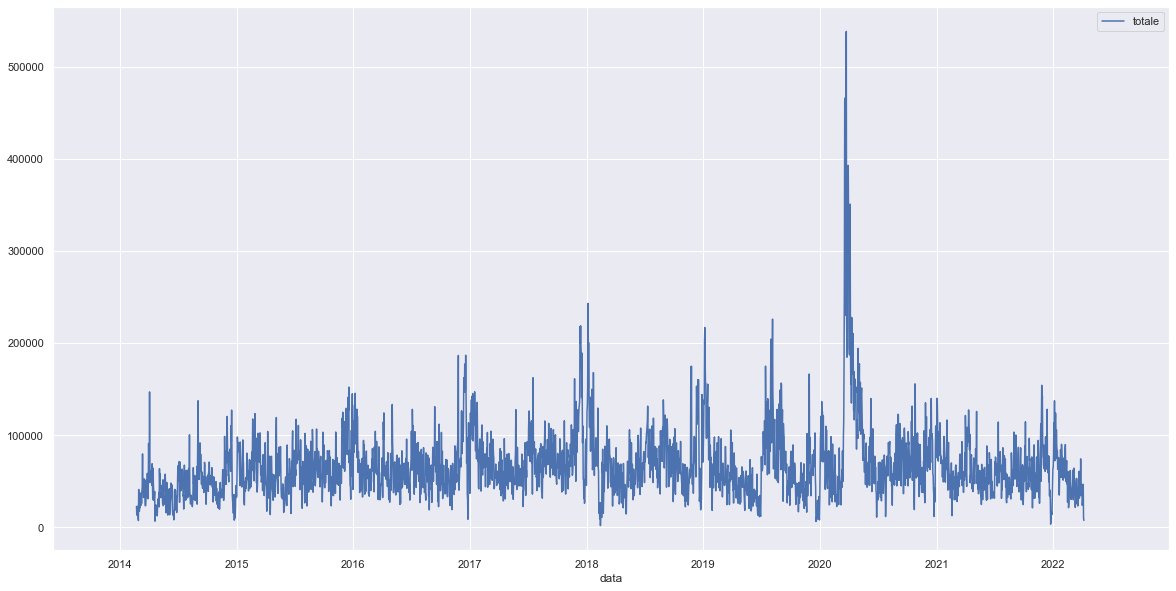

In [124]:
### Plot daily sells
fig, ax = plt.subplots(figsize=(20,10))
df_sells_day.plot(x='data', y='totale', ax=ax)
plt.xlim(left='2013-06-06', right='2022-12-31')

Text(1.0, 1.0, 'Sells per month')

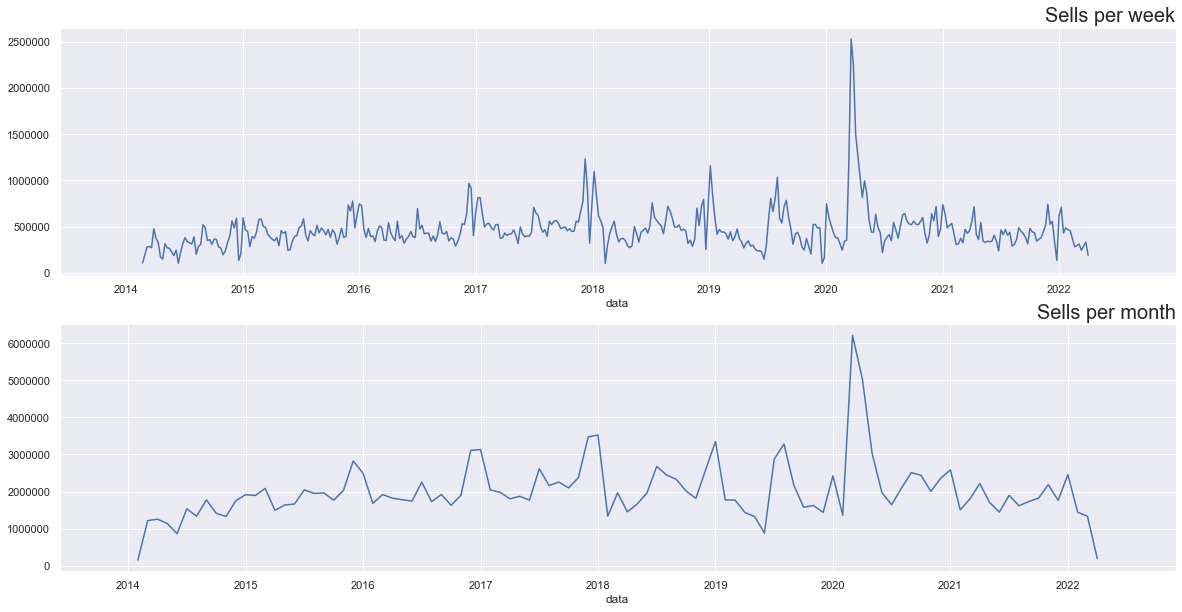

In [125]:
### Group by per data to sum total earnings (1 week and 1 month timeslice)
plt.figure(figsize=(20,10))

# 1 week sum
plt.subplot(2, 1, 1)
df_sells_day.groupby(pd.Grouper(key='data', freq='7d'))['totale'].sum().plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2022-12-31')
plt.title('Sells per week', loc='right', fontdict={'fontsize': 20})

# 1 month sum
plt.subplot(2, 1, 2)
df_sells_day.groupby(pd.Grouper(key='data', freq='1m'))['totale'].sum().plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2022-12-31')
plt.title('Sells per month', loc='right', fontdict={'fontsize': 20})

In [126]:
### Pivot by month
df_sells_day['anno'] = [d.year for d in df_sells_day['data']]
df_sells_day['mese'] = [d.month for d in df_sells_day['data']]

df_mese = pd.DataFrame(df_sells_day.groupby(by=['anno', 'mese'])['totale'].sum()).reset_index()
df_mese = df_mese.pivot(index="mese", columns="anno", values="totale")
df_mese.describe()

anno,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,4.000000e+00
mean,1.249578e+06,1.938444e+06,1.997196e+06,2.298046e+06,2.147691e+06,1.957926e+06,2.758411e+06,1.855226e+06,1.354194e+06
std,4.496960e+05,3.339884e+05,4.291439e+05,5.327952e+05,6.092255e+05,7.983349e+05,1.431321e+06,3.273135e+05,9.262150e+05
min,1.488231e+05,1.492607e+06,1.627219e+06,1.768157e+06,1.334476e+06,8.785999e+05,1.361682e+06,1.444479e+06,1.902151e+05
25%,1.175879e+06,1.740015e+06,1.737415e+06,1.952222e+06,1.778270e+06,1.436306e+06,1.995257e+06,1.681110e+06,1.045284e+06
50%,1.325950e+06,1.932309e+06,1.860432e+06,2.129405e+06,1.988325e+06,1.695611e+06,2.389943e+06,1.781493e+06,1.386064e+06
75%,1.472324e+06,2.034131e+06,2.002596e+06,2.436196e+06,2.483887e+06,2.350911e+06,2.641094e+06,1.969583e+06,1.694974e+06
max,1.774890e+06,2.825318e+06,3.109826e+06,3.473589e+06,3.526956e+06,3.347046e+06,6.214672e+06,2.585867e+06,2.454433e+06


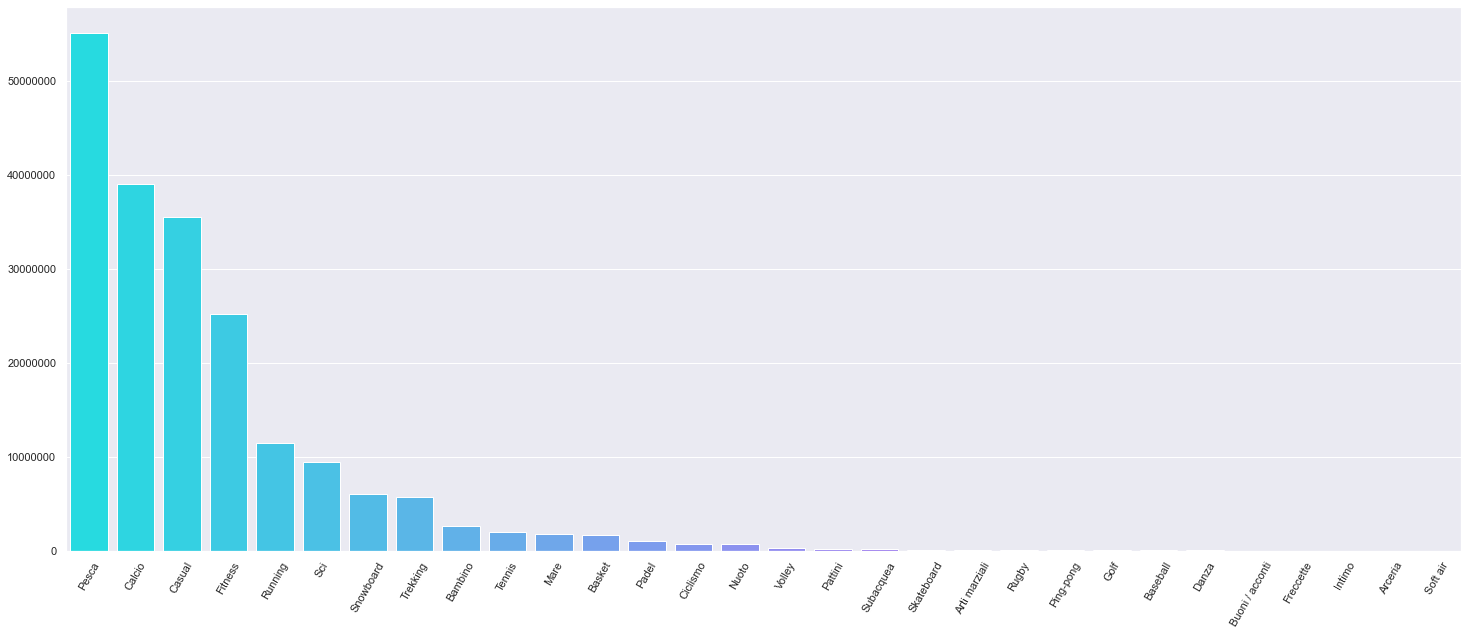

In [127]:
### Group by per category and sum up
df_groupby_settore = df.groupby(by=["settore"], sort=True)["totale"].sum().sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
sns.barplot(x=list(df_groupby_settore.index), y=list(df_groupby_settore.values), palette="cool")
plt.ticklabel_format(style='plain', axis='y')


<AxesSubplot:xlabel='data'>

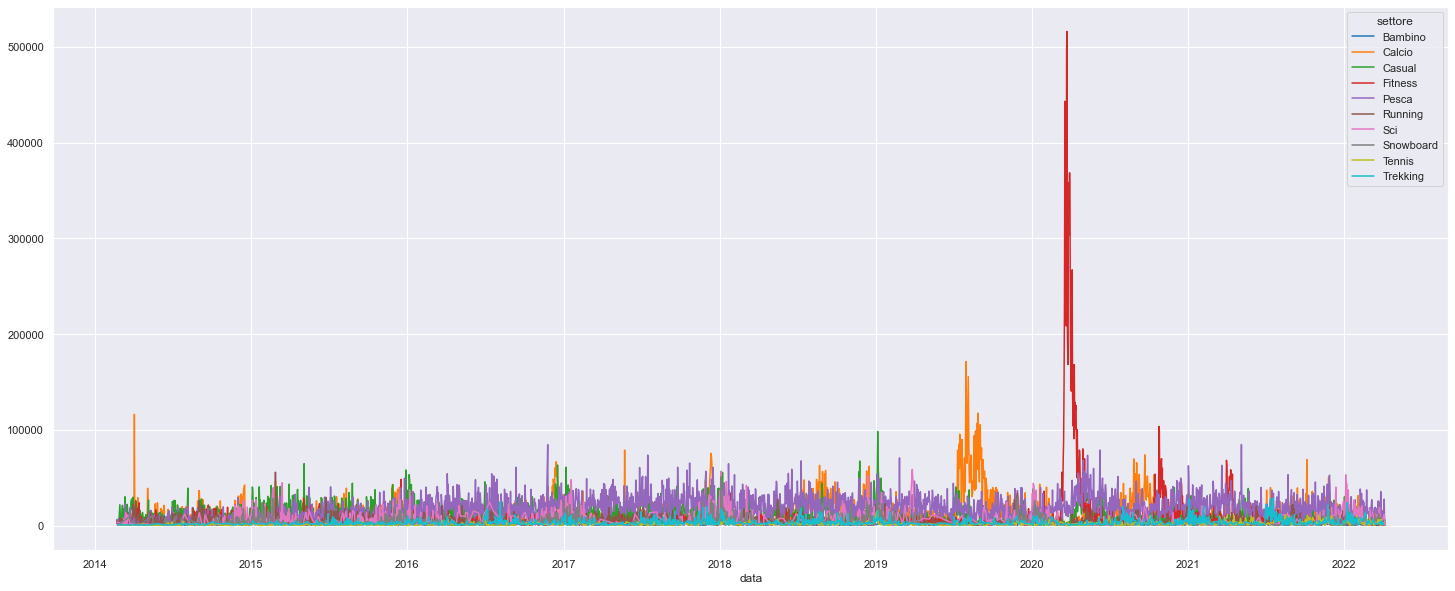

In [128]:
### time series group by higher sectors in total 
list_high_number_total = df_groupby_settore.index[0:10]
df_pivot_settore_and_data = (df[(df['data'] > '2014-02-20') & (df['data'] < '2022-04-08')].query("settore in @list_high_number_total")).pivot(index="data", columns="settore", values="totale")
plt.figure(figsize=(25,10))
sns.lineplot(data=df_pivot_settore_and_data, dashes=False, palette="tab10")

In [129]:
df_pivot_settore_and_data.describe()

settore,Bambino,Calcio,Casual,Fitness,Pesca,Running,Sci,Snowboard,Tennis,Trekking
count,1249.000000,2925.000000,2873.000000,2814.000000,2948.000000,2220.000000,1196.000000,1366.000000,972.000000,1514.000000
mean,2084.029736,13309.391921,12305.651730,8930.101446,18643.251957,5126.232239,7872.570886,4355.605007,2039.352294,3764.138137
std,2173.208435,13945.831456,9170.503593,28033.950556,11502.796926,4260.194013,8419.277251,4994.947934,2054.405058,3661.227758
min,81.870000,106.430000,162.100000,45.440000,36.840000,0.270000,2.730000,95.520000,36.840000,121.440000
25%,762.210000,5262.600000,5730.900000,2372.595000,10244.667500,2292.292500,1756.252500,1135.260000,614.030000,1335.300000
50%,1361.770000,9493.650000,10315.620000,4356.575000,16990.345000,3929.760000,5387.050000,2464.970000,1397.930000,2524.870000
75%,2677.150000,16000.400000,16511.810000,7788.430000,25198.020000,6871.755000,10902.360000,5645.072500,2863.402500,4947.202500
max,25858.090000,171365.370000,98255.460000,516104.930000,84700.250000,55733.000000,58780.480000,50980.720000,15268.760000,28574.540000


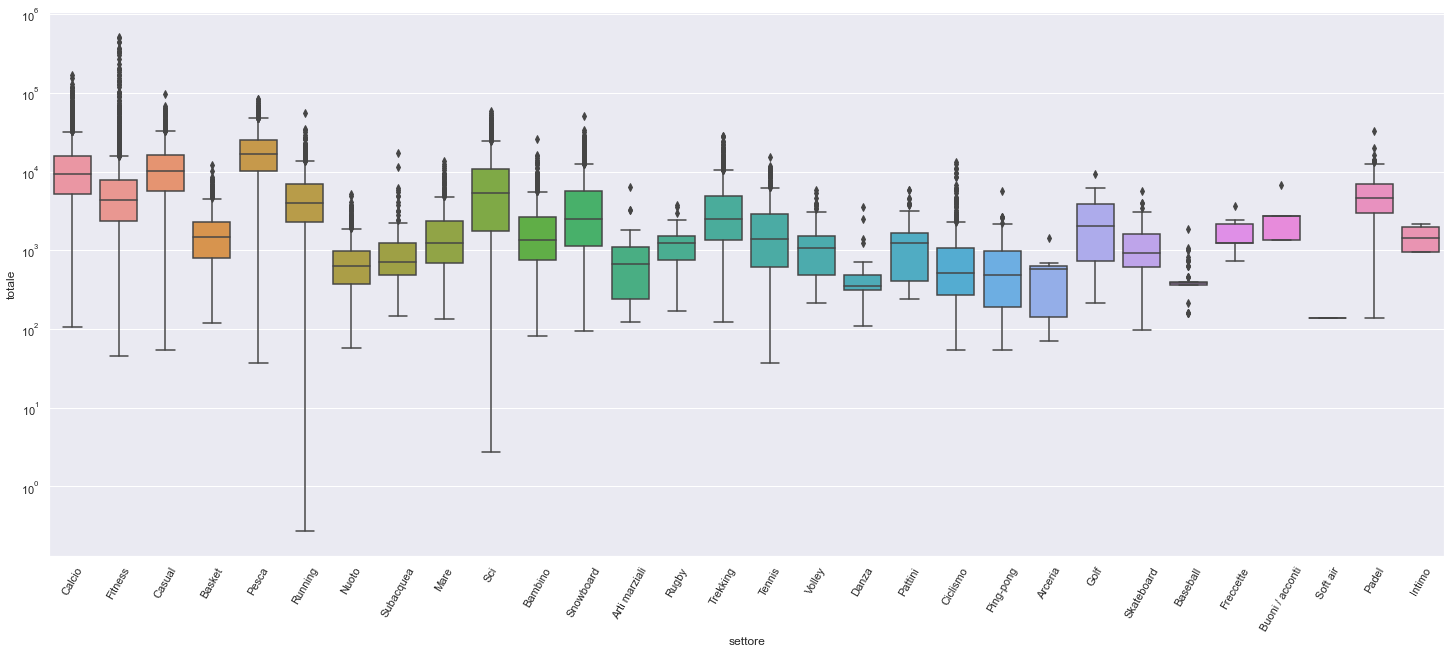

In [130]:
### boxplot to see correlation between cost spent and category
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
plot = sns.boxplot(data=df, x="settore", y="totale")
plot.set_yscale("log")

### Time series decomposition

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [132]:
df_sells_day_decomp = df_sells_day[(df_sells_day['data'] > '2014-02-20') & (df_sells_day['data'] < '2020-01-01')]
df_sells_day_decomp = df_sells_day_decomp.set_index('data')
df_sells_day_decomp['boxcox'], lam = boxcox(df_sells_day_decomp['totale'])

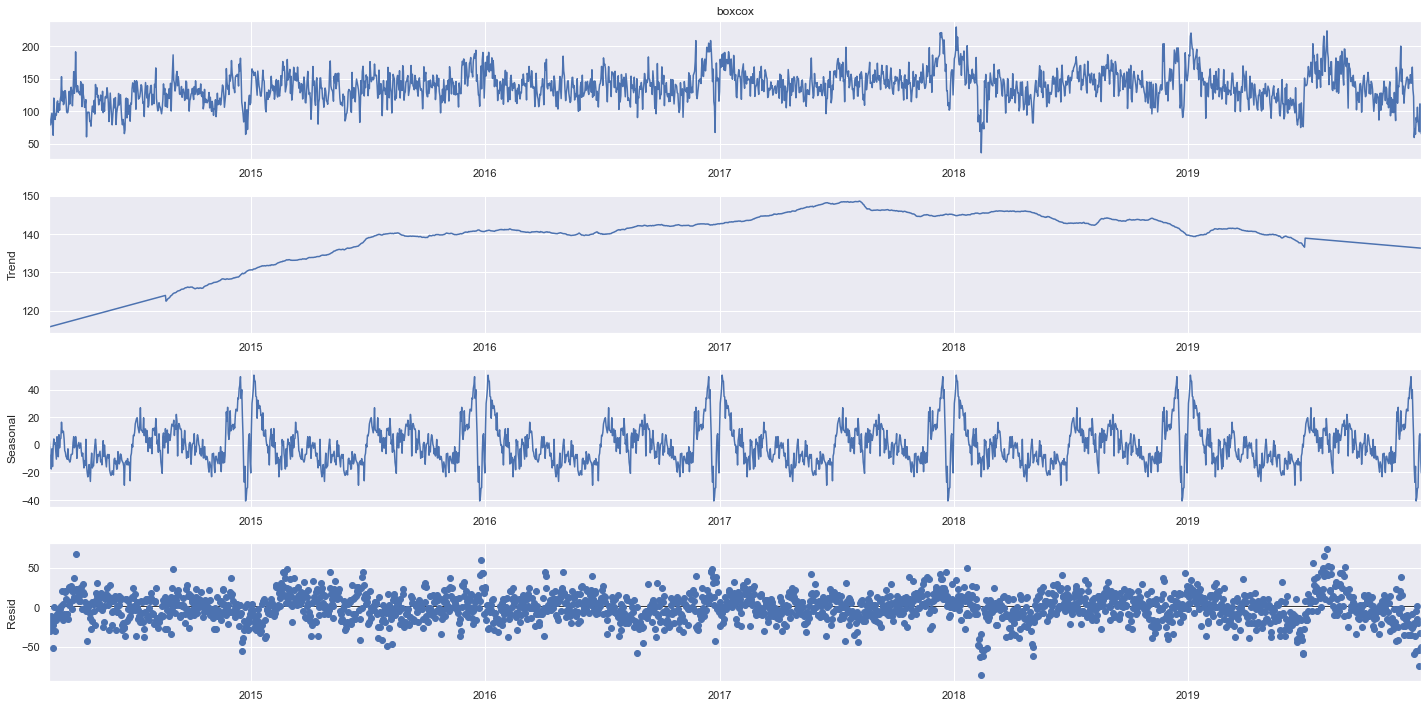

In [143]:
decompose = seasonal_decompose(df_sells_day_decomp['boxcox'], model='add', period=365, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose.plot()
plt.show()

### Time series modeling